# Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

### For classification visualization purpose ###
from sklearn.datasets import make_classification
from scipy.spatial.distance import cdist
from utils import visualize_svm_model, visualize_knn_model

### Import machine learning algorithms ###
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

plt.style.use('ggplot') # change plot style

# Exploratory Data Analysis (EDA)

In [2]:
data = pd.read_csv('../datasets/wine.csv')
data.head()

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


## Correlation matrix

<AxesSubplot:>

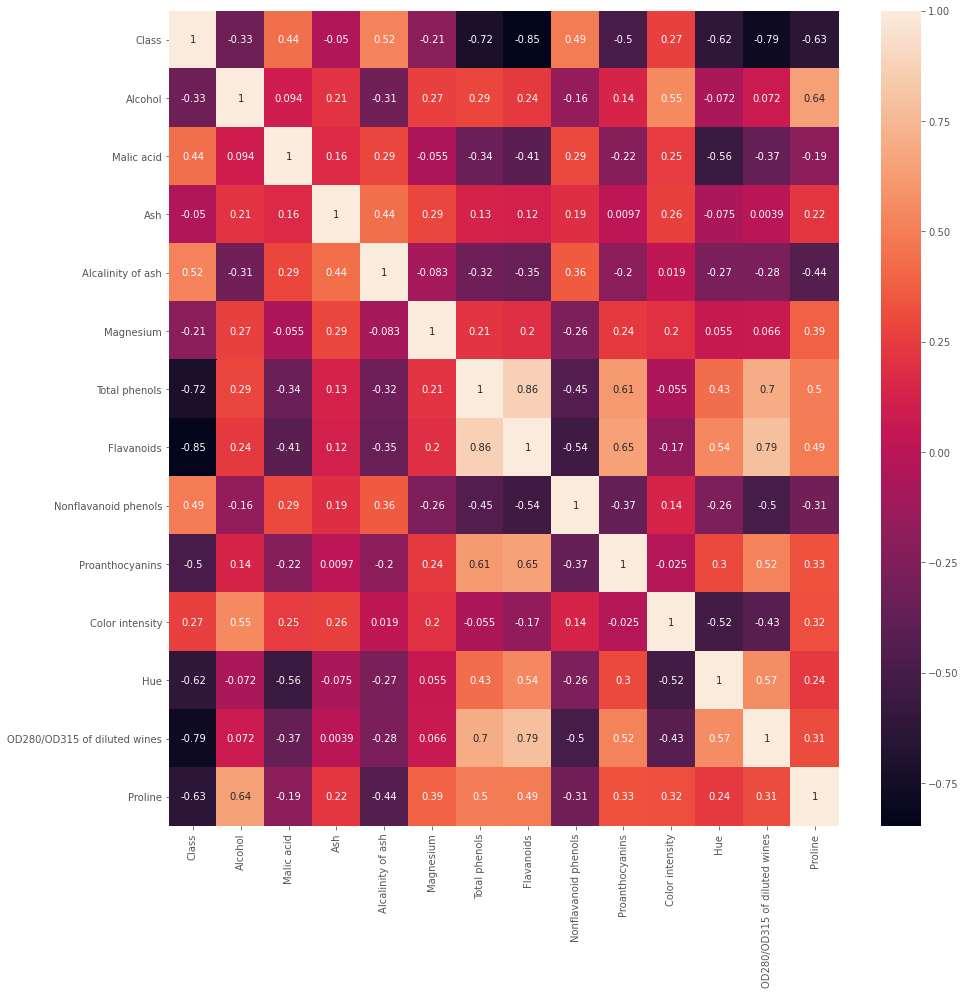

In [3]:
fig, ax = plt.subplots(figsize=(15, 15))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True)

### Attributes' distribution by class

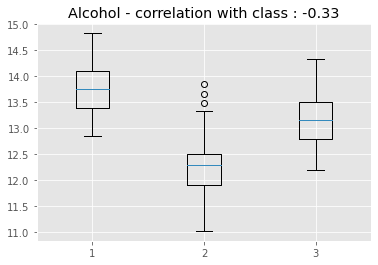

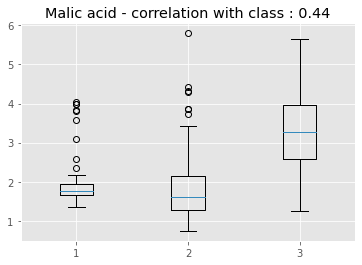

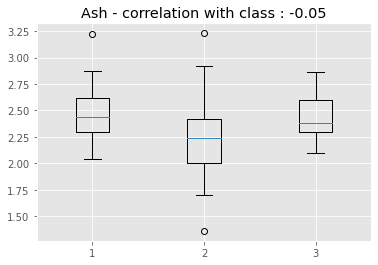

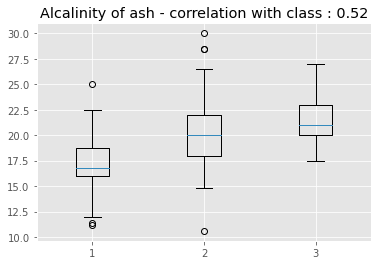

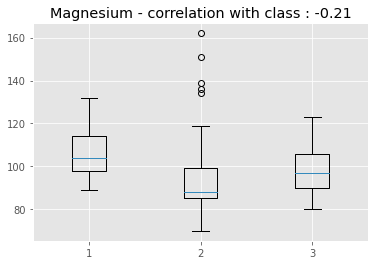

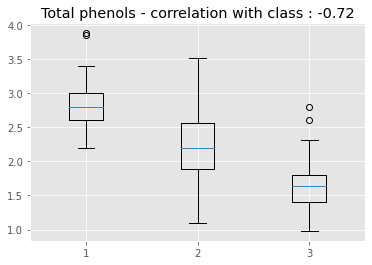

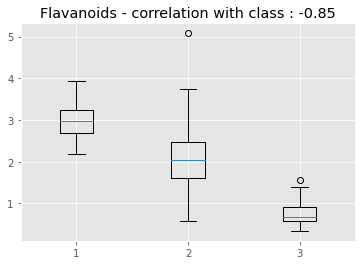

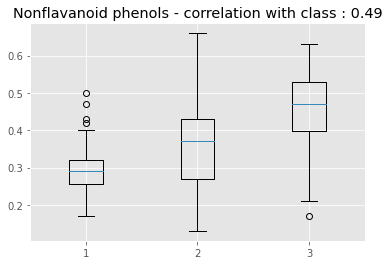

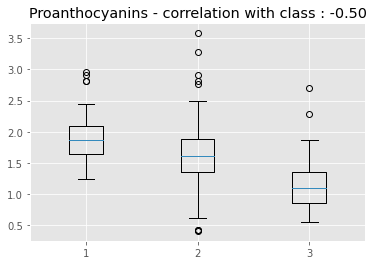

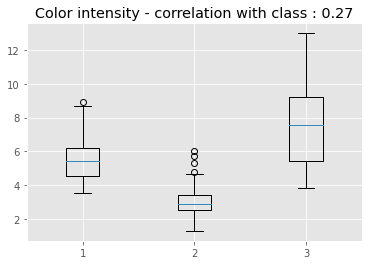

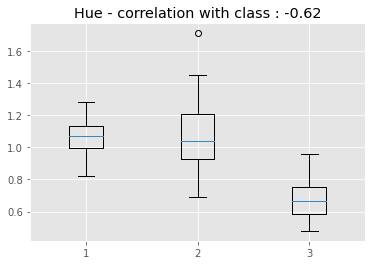

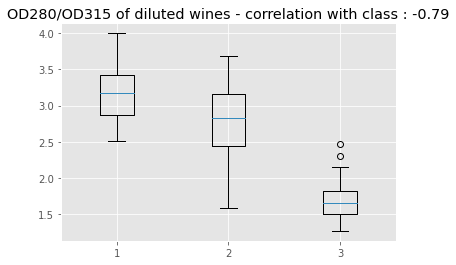

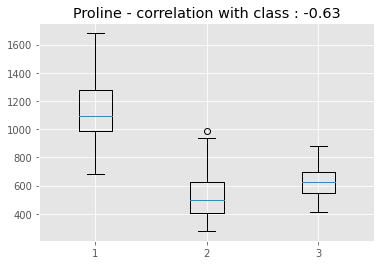

In [4]:
def visualize_attr_dist_by_class(data, attr):
    groups = []
    
    for _class in np.unique(data['Class']):
        groups.append(data[data['Class'] == _class][attr])
        
    corr = np.corrcoef(data['Class'], data[attr])[0, 1]
    plt.title(f'{attr} - correlation with class : {corr:.2f}')
    plt.boxplot(groups)
    plt.show()
    
for col in data.columns:
    if(col == 'Class'): continue
    visualize_attr_dist_by_class(data, col)

# Data cleaning and feature preprocessing

## 1. Handling missing data

In [5]:
# No missing data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Class                         178 non-null    int64  
 1   Alcohol                       178 non-null    float64
 2   Malic acid                    178 non-null    float64
 3   Ash                           178 non-null    float64
 4   Alcalinity of ash             178 non-null    float64
 5   Magnesium                     178 non-null    int64  
 6   Total phenols                 178 non-null    float64
 7   Flavanoids                    178 non-null    float64
 8   Nonflavanoid phenols          178 non-null    float64
 9   Proanthocyanins               178 non-null    float64
 10  Color intensity               178 non-null    float64
 11  Hue                           178 non-null    float64
 12  OD280/OD315 of diluted wines  178 non-null    float64
 13  Proli

## 2. Handling non-numeric data

In [6]:
# We have no non-numeric data

## 3. Feature scaling

In [8]:
# We still exclude our target and our categorical column
excluded = ['Class']

# 1. Create the scaler
scaler = StandardScaler()

# 2. Loop through all columns and rescale them
for col in data.columns:
    if(col not in excluded):
        # 3. Replace the original values with rescaled values (change to vector form)
        data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1))
        
data.head(3)

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,1,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148


# Model training

## 1. Select best model with cross validation